In [2]:
# Install required packages (if not available on server)
!pip install getdist

# Load required packages
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

%precision 3

# CONSTANTS
SPEED_OF_LIGHT = 2.998e5 # <--- Choose your favourite units, but make sure you're consistent!


# Hubble rate: look at equations (1) and (2) for the definition!
def Hubble(z, OmegaL, OmegaM, H0):
    OmegaK = 1. - OmegaL - OmegaM
    H = H0 * np.sqrt(OmegaL + OmegaM * (1+z)**3 + OmegaK * (1+z)**2)
    return H

# Integrate 1/H from x = 0 to x = z
def D(z, OmegaL, OmegaM, H0): # Yes, you can pass a function as argument!
    return H0 * integrate.quad(lambda x: 1/Hubble(x, OmegaL, OmegaM, H0), 0, z)[0]

def dL(z, OmegaL, OmegaM, H0): # luminosity distance, use eq.(3)
    OmegaK = 1. - OmegaL - OmegaM
    Dz = D(z, OmegaL, OmegaM, H0)

    if(OmegaK > 0) :
        dL = 1/np.sqrt( OmegaK) * np.sinh(np.sqrt(OmegaK) * Dz)
    if(OmegaK ==0) :
        dL = Dz
    if(OmegaK < 0) :
        dL = 1/np.sqrt(-OmegaK) * np.sin(np.sqrt(-OmegaK) * Dz)

    dL = 10.**4 * SPEED_OF_LIGHT / H0 * (1+z) * dL   # unit of H0 correction here: we _think_ it's MPC --> PC (10e6) x h -> H0 (10e-2)
    return dL

def mu(z, OmegaL, OmegaM, H0): # distance modulus -- use eq.(4)
    return 5 * np.log10( dL(z, OmegaL, OmegaM, H0) / 10 )

print("data import =======================================")

dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
display(data[0])

# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
# Data are in columns, so we either slice it by columns: arr[:,n]...
zs = data[:,1] # redshift
# ...or transpose the array and then slice by row: arr_transposed[n]
distance_modulus = data.T[2] # distance modulus
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.1/826.1 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for getdist: filename=getdist-1.4.7-py3-none-any.whl size=810432 sha256=080b74e77918542e1f081c26199b99a08f2e15d68dfd8865030076e310c11377
  Stored in directory: /root/.cache/pip/wheels/11/3e/8d/93c9494b4587d95165f805b376a4c7ed3ae670eb3cf7397389
Successfully built getdist
data import =======================================


array([      nan, 2.849e-02, 3.535e+01, 2.239e-01, 1.284e-01])

In [4]:
# A few thousand is a decent ballpark for the length of your MCMC chain
# NB: a few thousand *ACCEPTED* steps, not just attempted
N_steps = 20000

# Start from some very bad values, to show that the MCMC works anyway!
# (making sure you don't divide by zero anywhere...)
Omega_M = 0.5
Omega_L = 0.5
h = 0.5

#MCMCM

chi2_total_old = 999999
chi2_total_list = []

# create array that will hold triples of accepted parameters
params = []

# create a counter of accepted steps
accepted_steps = 0

# create random number generator object
rng = random.default_rng()

for i in range(N_steps) :

    log_Omega_M = np.log(Omega_M)
    log_Omega_L = np.log(Omega_L)

    # propose new values for log-transformed parameters
    log_Omega_M_new = log_Omega_M + np.random.normal(0, 0.01) #displaced in log space
    log_Omega_L_new = log_Omega_L + np.random.normal(0, 0.01) #displaced in log space

    # transform back to original space
    Omega_M_new = np.exp(log_Omega_M_new)
    Omega_L_new = np.exp(log_Omega_L_new)

    # propose new value for h
    h_new = h + np.random.normal(0, 0.05)

    if(Omega_M_new < 0.0) : continue # density cannot be < 0 for matter
    if(h_new < 0.0) : continue

    # loop over all datapoints
    chi2_total = 0.
    for j in range(len(zs)) :
        mu_model = mu(zs[j], Omega_L_new, Omega_M_new, h_new)
        chi2 = (mu_model - distance_modulus[j])**2 / error_distance_modulus[j]**2
        chi2_total += chi2

    if np.isnan(chi2_total) : continue

    # generate a random number between 0 and 1
    accept_bar = rng.random()

    # calculate the difference in chi squared between the proposed theta and the old theta
    chifactor = chi2_total_old - chi2_total;

    # trunctuate the chi squared difference (it would be computationally impossible to compute e to greater power than 20)
    if chifactor >= 20:
        chifactor = 20;

    # calculate ratio of likelihoods
    accept_coefficient = math.exp((chifactor) / 2.0)

    # if the ratio of likelihoods is larger than the randomly generated number, accept the proposed theta
    if accept_bar < accept_coefficient :

        accepted_steps += 1

        print("Accepting", chi2_total, "over", chi2_total_old, "since", accept_bar, "<", accept_coefficient, "run number:", i, "/", N_steps)

        # set the old theta to the proposed theta
        Omega_M = Omega_M_new
        Omega_L = Omega_L_new
        h       = h_new

        # set the old chi squared to the proposed chi squared
        chi2_total_old = chi2_total

        # add theta to the array
        params.append([Omega_M, Omega_L, h])

#print the list of parameters
for i in range(len(params)):
    print(i, "| Omega_m:", params[i][0], "Omega_l:", params[i][1], "h:", params[i][2])

# remove burn-in (graph looks much better without first 9 iterations)
params = params[9:]

#convert array of triples to 3 separate arrays
h_arr = np.array([])
OmegaM_arr = np.array([])
OmegaL_arr = np.array([])

for param in params:
    OmegaM_arr = np.append(OmegaM_arr, param[0])
    OmegaL_arr = np.append(OmegaL_arr, param[1])
    h_arr = np.append(h_arr, param[2])
#print the number of acepted steps

print ('The number of accetped steps is:', accepted_steps, 'and acceptance ratio is', accepted_steps/N_steps)

Accepting 3654.039786274995 over 999999 since 0.2005279871306035 < 22026.465794806718 run number: 0 / 20000
Accepting 2794.030248166579 over 3654.039786274995 since 0.6446613887270818 < 22026.465794806718 run number: 1 / 20000
Accepting 1609.495281448556 over 2794.030248166579 since 0.9143932908596091 < 22026.465794806718 run number: 4 / 20000
Accepting 1289.4151357491974 over 1609.495281448556 since 0.8860958309790128 < 22026.465794806718 run number: 5 / 20000
Accepting 682.7891762503439 over 1289.4151357491974 since 0.6225411759535021 < 22026.465794806718 run number: 8 / 20000
Accepting 668.9211316085418 over 682.7891762503439 since 0.28841766089985044 < 1026.6150611279081 run number: 20 / 20000
Accepting 668.5566614148628 over 668.9211316085418 since 0.09431321147014615 < 1.1998962525397432 run number: 38 / 20000
Accepting 666.9425955485317 over 668.5566614148628 since 0.8501702356073322 < 2.241248178376255 run number: 43 / 20000
Accepting 661.4252760277689 over 666.9425955485317 si

Removed no burn in
0.69  <  h  <  0.7  at  68 % CL
0.23  <  OmegaM  <  0.31  at  68 % CL
0.59  <  OmegaL  <  0.72  at  68 % CL
-0.02  <  Omegak  <  0.15  at  68 % CL




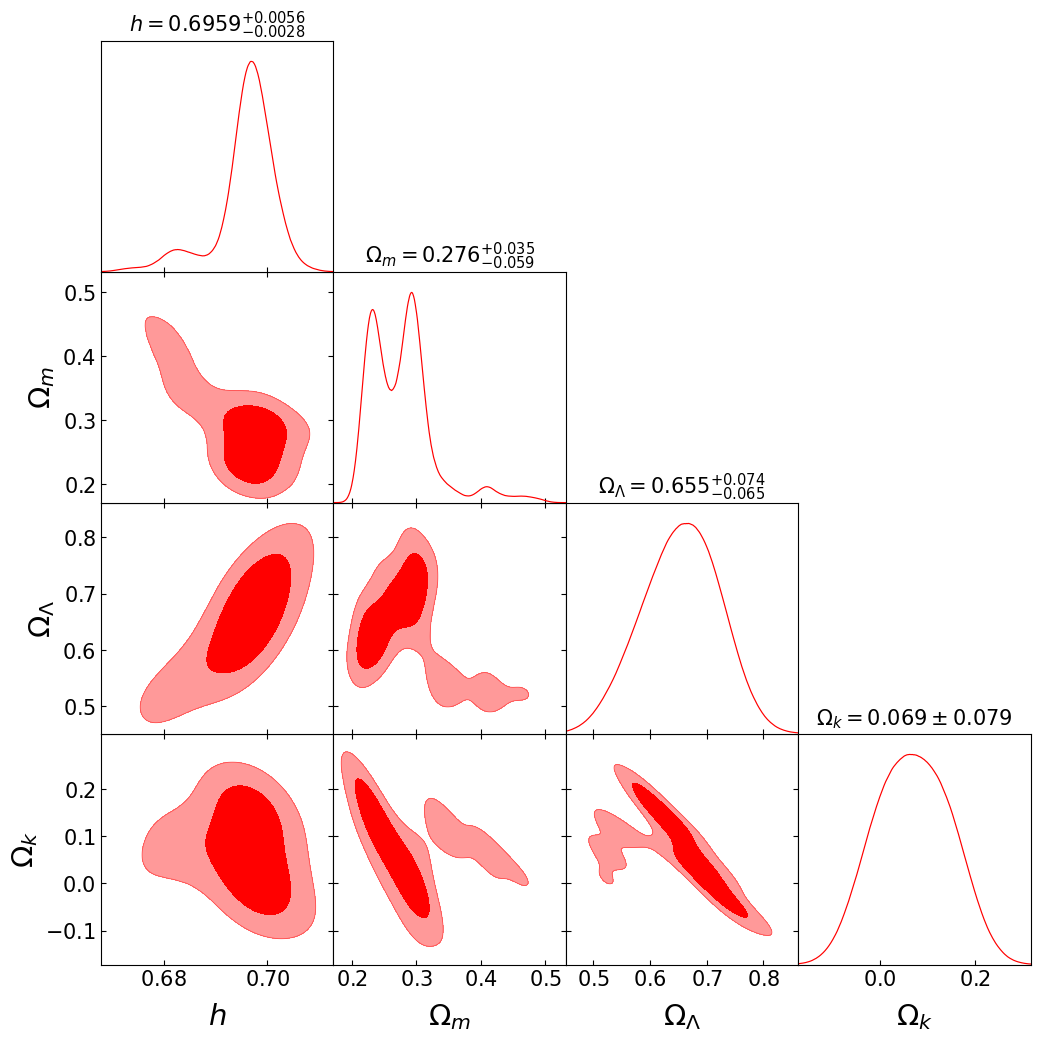

In [6]:
%matplotlib inline
# You can easily create new np.arrays that are functions of other np.arrays
Omegak_arr = 1. - OmegaM_arr - OmegaL_arr

# Let's define variable names and labels
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = len(my_names) # The number of variables we're plotting

# This creates a higher-dimensional array with all our data, shaped in the appropriate way...
my_samples = np.transpose(np.reshape([h_arr, OmegaM_arr, OmegaL_arr, Omegak_arr], (my_dim, len(h_arr))))
# ... to create an "MCSamples" data type, which GetDist can use
my_samples = MCSamples(samples = my_samples, labels = my_labels, names = my_names)

# The usual 1-sigma confidence level. You can change to 2- or 3-sigma if you want
conf_level = 0.6827

# This prints a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n")

#Triangle corner plot
contour_colors = ['red'] #change the color of the plot to red
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(my_samples, filled = True, title_limit=1, contour_colors=contour_colors)


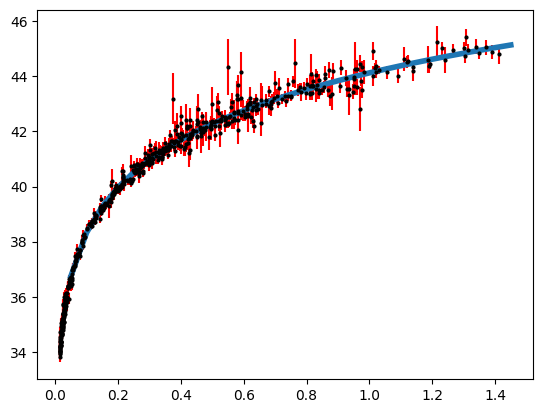

In [7]:
# plot the data against the last found values of omegas and h (they might not be the best of the ones found
# since we were exploring the parameter space, but the variations in chi squared are negligible at the end of the run)
plt.errorbar(zs, distance_modulus,\
             yerr=error_distance_modulus,\
             fmt='o',\
             color='black',\
             ecolor='red',\
             markersize=2)

modelzs = np.arange(0.05, 1.5, 0.05)
modelmus = []
for z in modelzs :
    modelmus += [mu(z, Omega_L, Omega_M, h)]

plt.plot(modelzs, modelmus, linewidth=4)
plt.show()